In [63]:
import pandas as pd 
import numpy as np 
import torch
import torchvision
import torchvision.transforms as transforms
import json 
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow_io
import tensorflow_io as tfio

In [64]:
label_df = pd.read_csv('/content/drive/MyDrive/SER- Project/VISTEC_src/misc/emotion_label.csv')
label_df.head()

,Unnamed: 0,filename,assigned_emo,majority_emo
0,0,s001_con_actor001_impro1_1.flac,Neutral,Neutral
1,1,s001_con_actor001_impro1_10.flac,Neutral,Neutral
2,2,s001_con_actor001_impro1_11.flac,Neutral,Neutral
3,3,s001_con_actor001_impro1_12.flac,Neutral,Neutral
4,4,s001_con_actor001_impro1_13.flac,Neutral,Neutral


In [65]:

def prep_fn(img):
    img = img.astype(np.float32) / 255.0 # [0,1]
    # img = (img - 0.5) * 2  # [0 -0.5 , 1 - 0.5] => [-0.5, 0.5] * 2 => [-1,1]
    return img

import librosa
from tensorflow.keras.utils import load_img, img_to_array
import librosa.display
import os
import glob
read_paths = glob.glob('/content/drive/MyDrive/SER- Project/spectogram/*')
train_dataset = []
train_label = []
img_size = (256,256,3)
label_dict  =dict(zip(label_df.filename,label_df.majority_emo))
emotion_dict = {'Neutral' : 1, 'Angry' :2 , 'Happy':3 , 'Sad' : 4, 'Frustrated':5,'None' : 0}
for path in read_paths:
      filename = os.path.basename(path).replace('.png','.flac') 
      filename =filename.replace('middle','con')
      #print(filename)
      label = label_dict[filename]
      #"print(label)
      label  = emotion_dict[label]
      
      
      img = img_to_array(load_img(
        path,
        grayscale=False,
        color_mode='rgb',
        target_size=img_size,
        interpolation='bilinear'))
      img = prep_fn(img)
      train_dataset.append(img)
      train_label.append(label)

train_dataset = np.array(train_dataset)


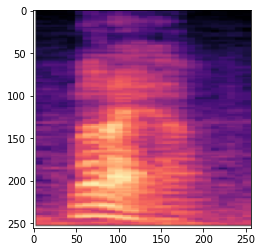

In [66]:
img_train = (train_dataset * 255).astype('uint8') 
plt.imshow(img_train[1])

In [67]:
values = train_label
n_values = np.max(values) + 1
train_label = np.eye(n_values)[values]

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( train_dataset, train_label, test_size=0.2, random_state=42)

In [69]:
X_train.shape

(244, 256, 256, 3)

In [70]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (256, 256, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model 
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(6)(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=['accuracy'])
model.compile(optimizer='adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [71]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 6)                 7686      
                                                                 
 softmax_float32 (Activation  (None, 6)                0         
 )                                                               
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainab

In [72]:
X_train = np.array(X_train)
y_train = np.array(y_train)


temp  = model.fit(X_train, y_train , epochs = 1000 )

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


8/8 [==============================] - 36s 3s/step - loss: 1.7845 - accuracy: 0.1967
Epoch 2/1000
8/8 [==============================] - 15s 2s/step - loss: 1.7246 - accuracy: 0.2418
Epoch 3/1000
8/8 [==============================] - 15s 2s/step - loss: 1.6936 - accuracy: 0.2541
Epoch 4/1000
8/8 [==============================] - 15s 2s/step - loss: 1.6929 - accuracy: 0.2336
Epoch 5/1000
8/8 [==============================] - 15s 2s/step - loss: 1.7054 - accuracy: 0.1844
Epoch 6/1000
8/8 [==============================] - 15s 2s/step - loss: 1.6979 - accuracy: 0.2541
Epoch 7/1000
8/8 [==============================] - 16s 2s/step - loss: 1.6966 - accuracy: 0.2582
Epoch 8/1000
8/8 [==============================] - 15s 2s/step - loss: 1.6963 - accuracy: 0.2254
Epoch 9/1000
8/8 [==============================] - 15s 2s/step - loss: 1.7036 - accuracy: 0.2213
Epoch 10/1000
8/8 [==============================] - 15s 2s/step - loss: 1.7015 - accuracy: 0.2418
Epoch 11/1000
8/8 [=============

In [73]:
model.save('/content/drive/MyDrive/SER- Project/EffNetZero ')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SER- Project/EffNetZero /assets
